# 1. Loading Dataset

Using Kaggle CLI to download dataset. To run this notebook, create a legacy API key on Kaggle and upload the 'kaggle.json' file to Google Colab.

In [3]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download samuelcortinhas/muffin-vs-chihuahua-image-classification

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification
License(s): CC0-1.0
 89% 423M/474M [00:03<00:00, 127MB/s] 
100% 474M/474M [00:03<00:00, 151MB/s]


In [7]:
! unzip muffin-vs-chihuahua-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/muffin/img_2_671.jpg  
  inflating: test/muffin/img_2_681.jpg  
  inflating: test/muffin/img_2_689.jpg  
  inflating: test/muffin/img_2_709.jpg  
  inflating: test/muffin/img_2_721.jpg  
  inflating: test/muffin/img_2_73.jpg  
  inflating: test/muffin/img_2_735.jpg  
  inflating: test/muffin/img_2_752.jpg  
  inflating: test/muffin/img_2_757.jpg  
  inflating: test/muffin/img_2_762.jpg  
  inflating: test/muffin/img_2_767.jpg  
  inflating: test/muffin/img_2_78.jpg  
  inflating: test/muffin/img_2_784.jpg  
  inflating: test/muffin/img_2_799.jpg  
  inflating: test/muffin/img_2_8.jpg  
  inflating: test/muffin/img_2_810.jpg  
  inflating: test/muffin/img_2_819.jpg  
  inflating: test/muffin/img_2_82.jpg  
  inflating: test/muffin/img_2_821.jpg  
  inflating: test/muffin/img_2_824.jpg  
  inflating: test/muffin/img_2_827.jpg  
  inflating: test/muffin/img_2_838.jpg  
  inflating: test/muffin/img_2_857.jpg  
  inflating

Setting up DataLoaders

In [10]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 32

trainset = datasets.ImageFolder('train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.ImageFolder('test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('chihuahua', 'muffin')

Visualizing images

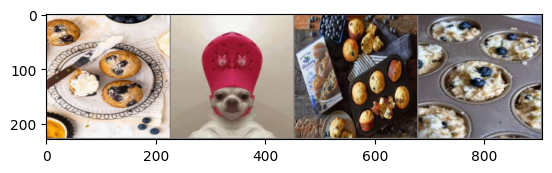

muffin chihuahua muffin muffin


In [18]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images = images[:4]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# 2. Defining CNN

In [30]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # first convolution
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # batch norm 1
        self.bn1 = nn.BatchNorm2d(32)
        # second convolution
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # batch norm 2
        self.bn2 = nn.BatchNorm2d(64)
        # third convolution
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # batch norm 3
        self.bn3 = nn.BatchNorm2d(128)
        # pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # define your FC layer(s)
        self.fc1 = nn.Linear(128 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, len(classes))

    def forward(self, x):
        # successive convolutions, BN, and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(x)
        # flatten all dimensions except batch
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # FC layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

## **Compiling the Network**
We will define our loss and optimizer here.

In [31]:
import torch.optim as optim

# define loss for multi-class classification
criterion = nn.CrossEntropyLoss()
# define your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## **Training the CNN**
Now let's train the CNN model we just created!

In [32]:
num_epochs = 3
# loop over the dataset multiple times
for epoch in range(num_epochs):
  for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics for every mini-batch
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss.item():.3f}')

print('Finished Training')

[1,     1] loss: 0.699
[1,     2] loss: 0.679
[1,     3] loss: 0.709
[1,     4] loss: 0.694
[1,     5] loss: 0.671
[1,     6] loss: 0.662
[1,     7] loss: 0.633
[1,     8] loss: 0.611
[1,     9] loss: 0.639
[1,    10] loss: 0.727
[1,    11] loss: 0.613
[1,    12] loss: 0.627
[1,    13] loss: 0.554
[1,    14] loss: 0.552
[1,    15] loss: 0.591
[1,    16] loss: 0.654
[1,    17] loss: 0.462
[1,    18] loss: 0.562
[1,    19] loss: 0.544
[1,    20] loss: 0.475
[1,    21] loss: 0.527
[1,    22] loss: 0.495
[1,    23] loss: 0.429
[1,    24] loss: 0.479
[1,    25] loss: 0.534
[1,    26] loss: 0.535
[1,    27] loss: 0.422
[1,    28] loss: 0.507
[1,    29] loss: 0.340
[1,    30] loss: 0.482
[1,    31] loss: 0.435
[1,    32] loss: 0.409
[1,    33] loss: 0.453
[1,    34] loss: 0.374
[1,    35] loss: 0.795
[1,    36] loss: 0.619
[1,    37] loss: 0.589
[1,    38] loss: 0.480
[1,    39] loss: 0.524
[1,    40] loss: 0.564
[1,    41] loss: 0.422
[1,    42] loss: 0.620
[1,    43] loss: 0.528
[1,    44] 

# 3. Evaluation

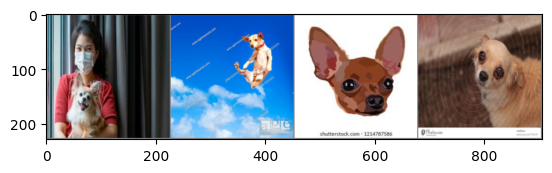

GroundTruth:  chihuahua chihuahua chihuahua chihuahua


In [33]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_display = images[:4]

# print images
imshow(torchvision.utils.make_grid(images_display))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [34]:
outputs = net(images)

In [35]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  chihuahua chihuahua chihuahua chihuahua


Let's test our model on more images to get a better idea of our test accuracy.

In [39]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on {total} test images: {100 * correct // total} %')

Accuracy of the network on 1184 test images: 73 %


In [38]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if prediction == label:
              correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: chihuahua is 80.0 %
Accuracy for class: muffin is 64.9 %
